# Model variance using Hermite polynomial regression

#### Peter Miller: Geoscience, Jackson School of Geosciences

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)



# Executive summary

The behavior of phenomena in our world are often nonlinear and thus capturing their subtlety with a linear model may often be inadequate. The goal for this project was to investigate the use of polynomial basis expansions of predictor features, specifically with Hermite polynomials, which provide nonlinear coefficients that can be fit with a regression and used to increase complexity in machine learning models. To investigate how polynomial basis functions are used to fit nonlinear phenomena I have created a streamlined workflow based on the Hermite polynomial section of Prof. Michael Pyrcz’s SubsurfaceDataAnalytics_polynomialRegression workflow. I have generalized the code and consolidated important sections into functions which are used to interrogate the effects of model order on the testing error.  Specifically, I have created a function to loop over the number of model realizations and output the mean squared error and the model variance for each realization. I have also added visualizations which show how randomizing the train/testing data selection affects the final model. While I understood the effect of model complexity on the variance/bias tradeoff in expected testing error, the ability to visualize this with any dataset is important for building an intuition about a given model.   

# Package import

In [1]:
import os                                                   # to set current working directory 
import numpy as np                                          # arrays and matrix math
import scipy                                                # hermite polynomials
import scipy.stats as st                                    # statistical methods
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # plotting functions
from sklearn.linear_model import LinearRegression           # linear regression with scikit learn
from sklearn.model_selection import train_test_split        # train and test split
from scipy import stats                                     # statistical summary from a 2D ndarray
import seaborn as sns                                       # Useful statistical visualizations
import random                                               # Produces pseudo random numbers
import warnings                                             # ignores warnings
warnings.filterwarnings('ignore') 
from sklearn.metrics import mean_squared_error              # For computing Mean squared error
import geostatspy.geostats as geostats                      # Geostats package from Professor Michael Pyrcz

# Function definitions

1) This block defines all functions used in the workflow. The comments above each function describe what the function is used for and how each part works. 

In [2]:
#Standardize function takes predictor and response feature dataframes and applies a standard normal transform.
#Output dataframes are the standard normal for the response and predictor features. 
def standardize(predictor_feature,response_feature):
    #create predictor and response feautre dataframes
    df_stand_pred = pd.DataFrame()
    df_stand_resp = pd.DataFrame()
    #get column names from dataframe
    col_pred = predictor_feature.columns
    col_resp = response_feature.columns
    #renames columns 
    col_names_pred = 'SN'+col_pred
    col_names_resp = 'SN'+col_resp
    #computes the standard normal transform for the predictor features
    for i in range(0,len(col_names_pred)):
        df_stand_pred[col_names_pred[i]] = geostats.nscore(predictor_feature,col_pred[i])[0]
    #computes standard normal transform for the response feature
    df_stand_resp[col_names_resp[0]] = geostats.nscore(response_feature,col_resp[0])[0]        
    #return SN transorm of predictor and response features as dataframes
    return(df_stand_pred,df_stand_resp)

#Builds dataframe from the basis expansions of the predictor feature of interest. 
def create_hermite_df(basis_exp,y_training_vals,poly_orders):
    #create hermite expansion dataframe
    df_hermite_train = pd.DataFrame()
    #add training values to dataframe
    df_hermite_train[y_training_vals.columns[0]] = y_training_vals.values.reshape(-1)
    #add predictor feature expansions to dataframe.
    for i in range(0,basis_exp.shape[1]):
        df_hermite_train[str(poly_orders[i])] = basis_exp[:,i]
    return(df_hermite_train)

#simple model hermite polynomial model for a single realization of the data.
def simple_mod(predictor_f,response_f,poly_orders,seed):
    predict_values = np.linspace(-4.0,4.0,200)
    herm = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(predictor_f,
                                                            response_f,test_size=0.25,random_state=seed)
    hermite_train = scipy.special.eval_hermitenorm(list(poly_orders),X_train.values.reshape(-1,1),out=None)
    df_hermite_train = create_hermite_df(hermite_train,y_train,orders)
    #fit expansion terms with y-training data
    herm.fit(df_hermite_train.iloc[:,1:], y_train) 
    #model prediction for plotting
    val_pred = herm.predict(scipy.special.eval_hermitenorm(list(poly_orders), 
                                                               predict_values.reshape(-1, 1), out=None))
    return(val_pred)

#Bootstrap MSE in model predictions for hermite polynomials
def bootstrap_var(predictor_f,response_f,poly_orders,realizations):
    #output lists for training and testing error measurments.
    training_var = []
    testing_var = []
    mse_train = []
    mse_test = []
    herm = LinearRegression()
    seed = 73073
    for j in range(0,realizations):
        X_train, X_test, y_train, y_test = train_test_split(predictor_f,
                                                            response_f,test_size=0.25,random_state=seed+j)
        #special model in scipy (specific orders of hermite polys)
        hermite_train = scipy.special.eval_hermitenorm(list(poly_orders),X_train.values.reshape(-1,1),out=None) 
        #Create hermite expansion dataframe
        df_hermite_train = create_hermite_df(hermite_train,y_train,orders)
        #fit expansion terms with y-training data
        herm.fit(df_hermite_train.iloc[:,1:], y_train) 
        #model prediction for plotting
        val_pred = herm.predict(scipy.special.eval_hermitenorm(list(poly_orders),
                                                               predict_values.reshape(-1,1), out=None))
        #prediction on training features
        y_train_pred = herm.predict(scipy.special.eval_hermitenorm(list(poly_orders),
                                                                   X_train.values.reshape(-1,1),out=None))
        #prediction on testing features
        y_test_pred = herm.predict(scipy.special.eval_hermitenorm(list(poly_orders),
                                                                  X_test.values.reshape(-1,1),out=None))
        #MSE training and testing error
        mse_train.append(mean_squared_error(y_train,y_train_pred))
        mse_test.append(mean_squared_error(y_test,y_test_pred))
        #Training and testing variance 
        training_var.append(np.std(y_train.values-y_train_pred))
        testing_var.append(np.std(y_test.values-y_test_pred))
    return(mse_train,mse_test,training_var,testing_var)

# Import Data and data summary statistics

The dataset used for this project  was collected onboard IODP expedition 341 and can be found here: https://web.iodp.tamu.edu/LORE/?reportName=mad&appl=LORE&action=show&filters=%5B%22x_expedition%20in%20(%27341%27)%22,%22x_site%20in%20(%27U1417%27)%22%5D&postretrieve=%7B%22scale_id%22:%2211331%22%7D

This data consits of moisture and density measurments of core samples taken from drill site U1417 on the incoming plate in the Gulf of Alaska. I have cleaned these data, reducing it to a few key features which track porosity, bulk density, and p-velocity with depth. I computed the P-velocity using Vp-porosity relationship for marine sediment published by Hoffman and Tobin (2004). The features are listed below:

**Predictor Features:**

* **Depth (m):** Sample depth at drill site U1417
* **Bulk Density (g/cm^3):** Bulk density of the oceanic mud at sech sample depth
* **Grain Density (g/cm^3):** Density of the grains at each sample
* **Porosity (fractional):** fraction of sample occupied by voids
* **Void Ratio (fractional):** ratio of the volume of sample occupied by voids to volume occupied by grains 

**Response Feature**

* **Vp (km/s):** P-wave velocity of the bulk sample computed using Vp-por relation in Hoffman and Tobin (2004)

Citation:

Hoffman, N. W., and H. J. Tobin (2004), An empirical relationship between velocity and porosity for underthrust sediments in the Nankai Trough accretionary prism, Proc. Ocean Drill. Program Sci. Results, 190/196, 1–23

In [3]:
#Import data from CSV file as a dataframe
df = pd.read_csv('https://raw.githubusercontent.com/pmiller14/PGE_383_project_data/main/U1417_MAD.csv') 
#Summary statistics data
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Depth m,220.0,316.192409,200.172229,0.430000,160.770000,273.920000,470.395000,706.620000
Bulk Den. [g/cm3],220.0,1.880186,0.189167,1.438000,1.790750,1.898000,1.975250,2.938000
Grain den. (g/cm3),220.0,2.839341,0.141040,1.904000,2.820500,2.841000,2.862000,3.886000
Porosity,220.0,0.528659,0.091872,0.037000,0.479750,0.517000,0.580250,0.795000
Void ratio,220.0,1.214318,0.514550,0.039000,0.920500,1.070500,1.385250,3.889000
Vp [km/s],220.0,1.702696,0.237020,1.509403,1.612028,1.680988,1.734765,4.796972


# Add noise to Vp data

1) Since Vp data was computed from the measured porosity values, I have added noise Vp values to simulate measurment error.

The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubsurfaceDataAnalytics_kNearestNeighbour.ipynb from [GeostatsGuy GitHub](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_kNearestNeighbour.ipynb).

In [4]:
#Utilizes method to add noise to response feature from Professor Michael Prycz: SubsurfaceDataAnalytics_kNearestNeighbour.ipynb
seed = 73073
np.random.seed(seed = seed)                                
noise_stdev = 0.05
#define predictor and response feature column names
predictor_feat_name = 'Porosity'
response_feat_name = 'Vp [km/s]'
#Adds noise to response feature
df[response_feat_name] = df[response_feat_name] + np.random.normal(loc=0.0,scale=noise_stdev,size = len(df))

# Standard normal transform of the dataset and polynomial regression assumptions

1) Basis expansion of features utilizes a a set of polynomial functions with degrees 1...k to compute the expansion. Thus, for a single predictor feature, there will be k basis expansion terms. If these basis expansion functions are non-orthoganal the outputs will potentially be highly correlated with each other. To avoid or minimize this correlation, orthogonal basis functions can be used to reduce correlation between basis expansion terms (see explanation on Hermite basis functions below).

## Assumptions of polynomial regression

1) The only error in the model is the error in the response feature. The predictor feature values are assumed to be error free. 

2) The error in the response feature is homoscedastic, meaning the error in the feature has constant variance. 

3) Because this polynomial regression, it is assumed that the relationship between the predictor feature and response feature is non-linear. Otherwise, the best approximation would be linear relationship without the need for basis expansion. 

## Hermite Polynomials

1) Two sequential Hermite poynomial basis functions ($H_m(X)$ and $H_n(X)$) are only orthogonal if they satisfy:$\int_{-\infty}^{\infty}{H_m(X)H_n(X)w(X)dx = 0}$

where $w(X) = e^{\frac{-x^2}{2}}$

Because of the w(X) term, the data need to transformed to have a distribution with a mean = 0 and variance = 1. This means that the input features MUST be gaussian distributed. 

The code block below uses the function defined above to compute the gaussian transform of the predictor and response feature.

```python
standardize(pred_feat,resp_feat)                                       
```

In [5]:
#Get nnumber of dataframe columns
N = df.shape[1]
#Deep copy of dataframe
pred_deep_copy = df.copy(deep=True)
#Create dataframe for predictor and response features 
pred_feat = pred_deep_copy.drop(columns=response_feat_name)
resp_feat = pd.DataFrame({response_feat_name:df[response_feat_name].values})

df_pred_stand, df_resp_stand = standardize(pred_feat,resp_feat)

#Summary statistics for standard normal transformation of predictor features
df_pred_stand.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SNDepth m,220.0,0.000817,0.997096,-2.657867,-0.670931,-3.441691e-15,0.670931,2.837597
SNBulk Den. [g/cm3],220.0,0.005370,0.995322,-2.479283,-0.670931,5.696924e-03,0.670931,2.837597
SNGrain den. (g/cm3),220.0,0.011828,0.995255,-2.570115,-0.649775,5.696924e-03,0.681659,2.837597
SNPorosity,220.0,0.002243,1.010142,-3.598987,-0.649775,5.696924e-03,0.670931,2.837597
SNVoid ratio,220.0,-0.000900,1.004885,-3.246174,-0.670931,-3.441691e-15,0.670931,2.837597


In [6]:
#Summary statistics for transform of response feature.
df_resp_stand.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SNVp [km/s],220.0,0.001402,0.995565,-2.529102,-0.670931,-3.441691e-15,0.670931,2.837597


# Visualize standard normal transform

1) Because Hermite polynomials requre that the features have a standard normal distribution, the seaborn pairplot is a great method to visualizes the data and check if the distributions have a mean of 0 and variance of 1.  

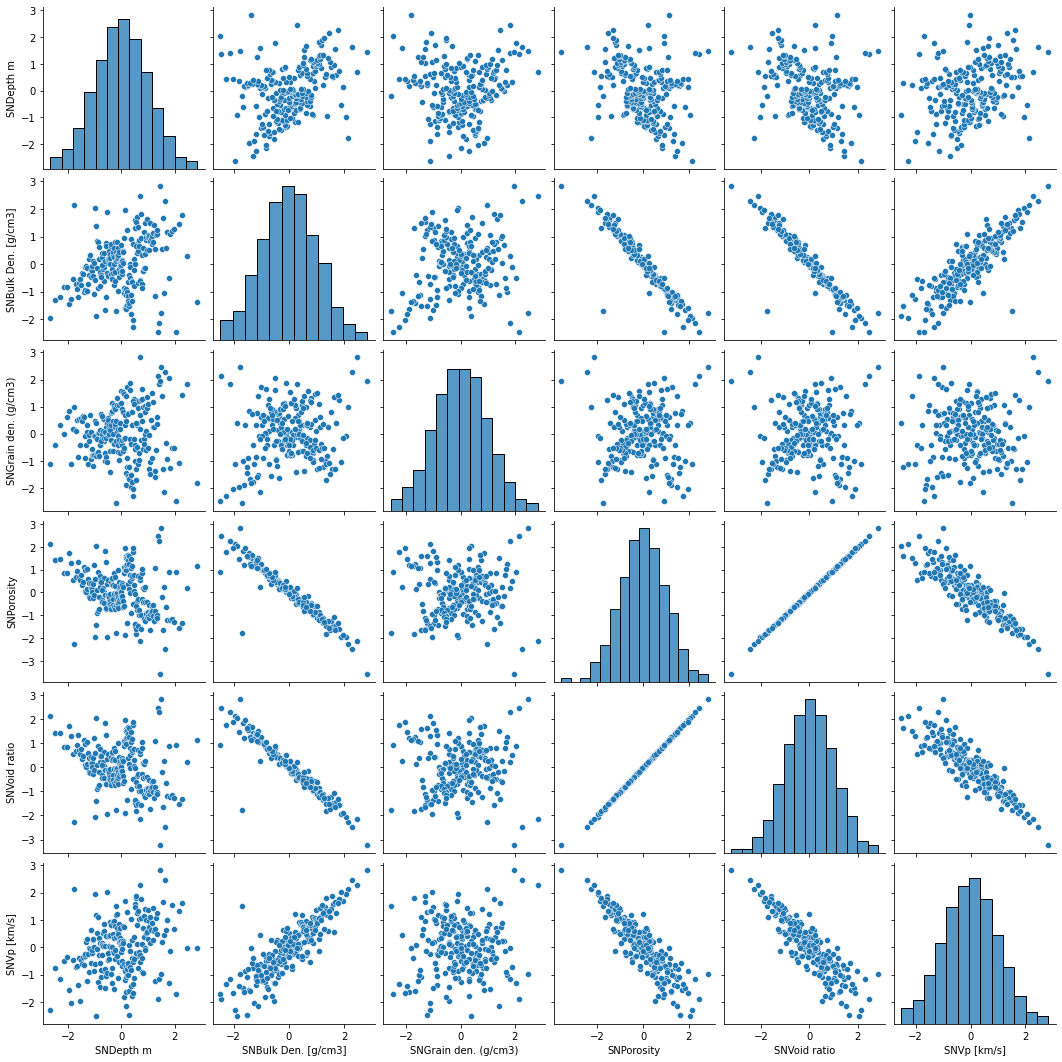

In [7]:
#Show correlations between features using dataframe.corr() method. 
full_std_data = df_pred_stand
full_std_data[df_resp_stand.columns[0]] = df_resp_stand

#pairplot showing standarized predictor features. 
#All variables are gaussian distributed and have mean = 0 and standard dev = 1. 
sns.pairplot(full_std_data,vars=full_std_data.columns)

# Correlations between all features 

1) Recompiles all standardized features into a single dataframe and computes the correlation matrix.

2) Plots correlation matrix as a heat map. 

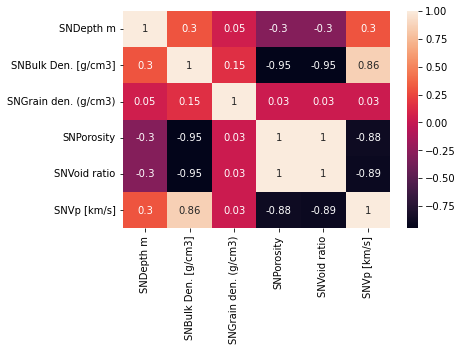

In [8]:
#Show data correlations as a heatmap (dark and light colors show features with high correlation)
data_corr = full_std_data.corr().round(2)
sns.heatmap(data=data_corr, annot=True);

# Train/Test split and Hermite basis expansion of a predictor feature

1) This block creates a train/test split of the predictor feature and the response feature.

2) Then sets the order of the expansion and computes the basis expansion of the predictor feature.

3) Computes the correlation between basis expansion terms and plots as a heat map

### Note on basis correlation 
The hermite polynomials do an ok job with decorrelating the outputs of the basis expansion. Generally, the even and odd polynomial outputs would be highly correlated due to similar shapes of the polynomial, however, the Hermite basis functions clearly reduce this correlation. You can see the correlation between even and odd outputs are generall not larger than +-0.4 with the exception of order 3 & 5 and order 4 & 6. It does appear, however, that with increasing polynomial order, the correlation also increases. 

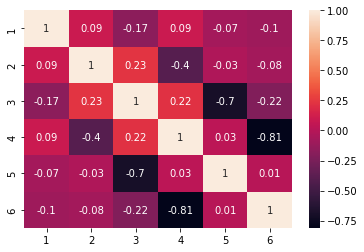

In [9]:
#Create train/test split with predictor feature and response feature
#Train test split is 25% and the random seed is 73073
X_train, X_test, y_train, y_test = train_test_split(df_pred_stand['SN'+predictor_feat_name], df_resp_stand,
                                                    test_size=0.25, random_state=73073)
#Set orders of polynomial
n = 6
orders = (np.arange(0,n+1,1))
#Scipy function to apply hermite polynomial basis expansion to the training predictor features. 
hermite_train = scipy.special.eval_hermitenorm(list(orders), X_train.values.reshape(-1,1), out=None) 

#Create dataframe from hermite polynomial basis expansion
dfH_train=create_hermite_df(hermite_train,y_train,orders)

#Show correlation between basis expansion terms of the predictor feature
hermit_corr = dfH_train.iloc[:,2:].corr().round(2)
#show heat map of correlation between basis expansion terms
sns.heatmap(data=hermit_corr, annot=True);

# Example model prediction

1) This block fits the Hermite expansion terms with a linear regression.

2) Computes the expected values for a sample range of values and at the X_test locations

3) Plots training/testing, and predictions 

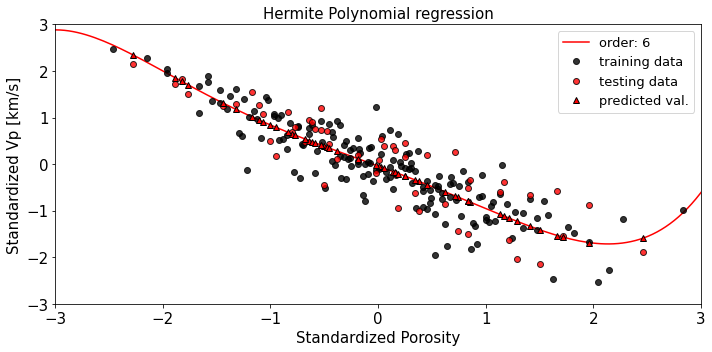

In [10]:
#Fit hermite expansion 
herm = LinearRegression() 
herm.fit(dfH_train.iloc[:,1:], y_train) 
#array for predictor feature range
predict_values = np.linspace(-4.0,4.0,200)
# compute model for predictor feature range AND for each X_test value
mod_pred_values = herm.predict(scipy.special.eval_hermitenorm(list(orders),predict_values.reshape(-1,1),out=None))
resp_pred_vals = herm.predict(scipy.special.eval_hermitenorm(list(orders), X_test.values.reshape(-1,1),out=None))

#Plot model of chosen order, training data, testing data, and predicted testing values.
fig = plt.figure(figsize=(10,5))
plt.subplot(111)
plt.plot(predict_values,mod_pred_values,label='order: %d'%orders[-1],color = 'red') 
plt.plot(X_train.values, y_train.values.reshape(-1), 'o', 
         label='training data', color = 'k', alpha = 0.8, markeredgecolor = 'k')
plt.plot(X_test.values, y_test.values.reshape(-1), 'o', 
         label='testing data', color = 'r', alpha = 0.8, markeredgecolor = 'k')
plt.plot(X_test.values,resp_pred_vals ,'^',label='predicted val.',color = 'red',markeredgecolor = 'k') 
plt.title('Hermite Polynomial regression',fontsize=15)
plt.xlabel('Standardized %s'%predictor_feat_name,fontsize=15)
plt.ylabel('Standardized %s'%response_feat_name,fontsize=15)
plt.tick_params(axis='both',labelsize=15)
plt.xlim(-3,3); 
plt.ylim(-3,3);
plt.legend(loc='upper right',fontsize=13);
plt.tight_layout()

# MSE and model variance for 1000+ Train/test split realization

1) Compute the MSE and model variance for model 1000+ realizations where the train/test split is randomized begining with seed = 73073 and iteratively changing within the function. The default is set to 2000 but can be changed by the user.
```python 
bootstrap_var(df_pred_stand[predictor_feat_name],df_resp_stand,orders,nreal)
```
where 
```python
df_pred_stand[predictor_feat_name], df_resp_stand
``` 
are the predictor and response features respectively. Orders is the list of expansion terms and nreal is the number of model realizations.

2) This function will output the train/testing mean-squared-error and the model variance for each realization. The order of the expansion is set to 6 as default but can be changed by the user at their discretion. 

In [11]:
#set number of realizations
nreal = 2000
#Set orders of polynomial
n = 6
orders = np.arange(0,n+1,1)

#For each realization, conduct a random train/test split -> compute the hermite basis expansion
#on the training data, then compute the model and the MSE
mse_trn,mse_tst,trnvar,tstvar= bootstrap_var(df_pred_stand['SN'+predictor_feat_name],df_resp_stand,orders,nreal)

# Results 1: Plot data, models, and error for each realization

1) Visualize 100 realizations of hermite polynomial expansion for 100 randomly sampleed train/test splits (grey model curves) compared to the data. This utilizes the:

```python
simple_mod(predictor_feature,response_feature,order,seed=73073)
```
function defined in the function definition section.

2) Plot histogram for 1000+ realization of the training and testing mean squared error.  

3) Plot histogram for 1000+ realizations of the training and testing model variance

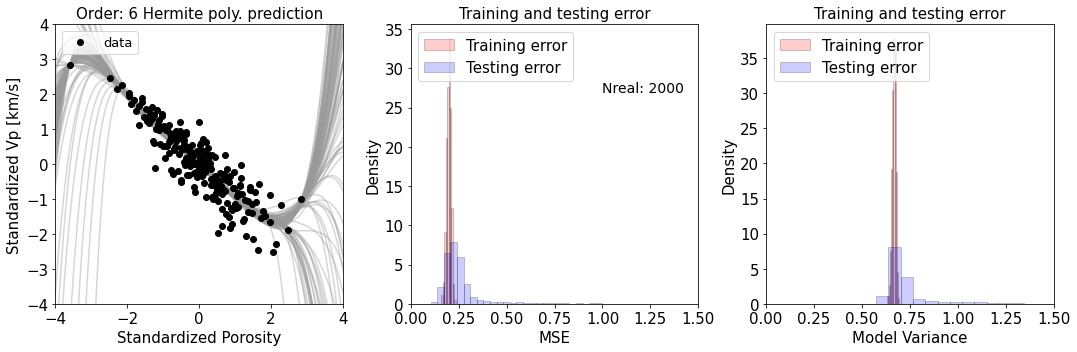

In [12]:
#Plot feature data with 100 realizations of the model to show variablity.
fig = plt.figure(figsize=(15,5))
plt.subplot(131)
for i in range(0,100):
    plt.plot(predict_values,simple_mod(df_pred_stand['SN'+predictor_feat_name],df_resp_stand,orders,seed=73073+i),
             alpha=0.4,c='0.6')
plt.plot(df_pred_stand['SN'+predictor_feat_name].values, df_resp_stand.values,'o',label='data',c = 'k')
plt.ylabel('Standardized %s'%response_feat_name,fontsize=15)
plt.xlabel('Standardized %s'%predictor_feat_name,fontsize=15)
plt.title('Order: %s Hermite poly. prediction'%orders[-1],fontsize=15)
plt.tick_params(axis='both',labelsize=15)
plt.legend(loc='upper left',fontsize=13)
plt.ylim([-4,4])
plt.xlim([-4,4])

#plot histogram of MSE for both training and testing error
plt.subplot(132)
plt.hist(mse_trn, facecolor='red',bins=10,alpha=0.2,density=True,
         edgecolor='black',label='Training error')
plt.hist(mse_tst, facecolor='blue',bins=np.linspace(0,1,30),
         alpha=0.2,density=True,edgecolor='black',label='Testing error') 
plt.title('Training and testing error',fontsize=15)
plt.xlim([0,1.5]); 
plt.text(1,27,'Nreal: %d'%nreal,fontsize=14)
plt.tick_params(axis='both',labelsize=15)
plt.xlabel('MSE',fontsize=15); 
plt.ylabel('Density',fontsize=15); 
plt.legend(loc='upper left',fontsize=15)

#plot histogram of model variance for both training and testing error. 
plt.subplot(133)
plt.hist(np.sqrt(trnvar), facecolor='red',bins=10,alpha=0.2,density=True,
         edgecolor='black',label='Training error')
plt.hist(np.sqrt(tstvar), facecolor='blue',bins=30,
         alpha=0.2,density=True,edgecolor='black',label='Testing error') 
plt.title('Training and testing error',fontsize=15)
plt.xlim([0,1.5]); 
plt.tick_params(axis='both',labelsize=15)
plt.xlabel('Model Variance',fontsize=15); 
plt.ylabel('Density',fontsize=15); 
plt.legend(loc='upper left',fontsize=15)
plt.tight_layout()

# Results 2: Visualize how MSE and model variance vary with model complexity

1) Compute Mean-squared-error and model variance for incrementally increasing hermite polynomial complexity ($h_0(x)$ to $h_{14}(x)$)

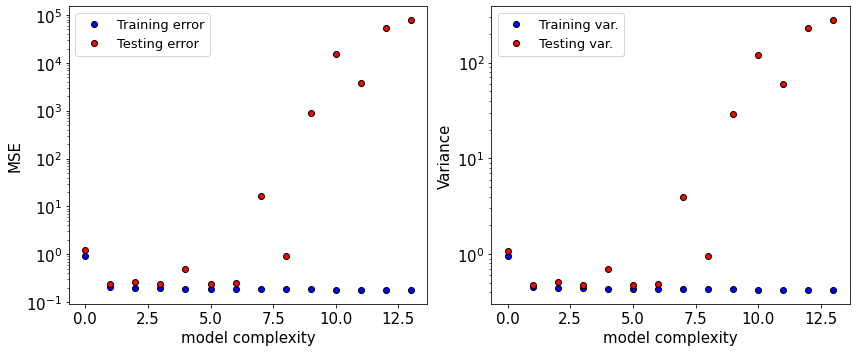

In [13]:
#set up lists which will be populated by the train/testing MSE and variance
msetrain_com = []
msetest_com = []
trn_var_com = []
tst_var_com = []
#sample array for complexity
complexity = np.arange(0,14,1)

#Compute MSE and variance for training and testing predictions
for i in range(0,14):
    nr=1
    orders = (np.arange(0,i+1,1))
    msetrain,msetest,trn_var,tst_var=bootstrap_var(df_pred_stand['SN'+predictor_feat_name],df_resp_stand,orders,nr)
    msetrain_com.append(msetrain)
    msetest_com.append(msetest)
    trn_var_com.append(trn_var)
    tst_var_com.append(tst_var)

#Plot train/test MSE as a function of model complexity
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(complexity,msetrain_com,'o',c='b',label='Training error',markeredgecolor='k')
plt.plot(complexity,msetest_com,'o',c='r',label='Testing error',markeredgecolor='k')
plt.ylabel('MSE',fontsize=15)
plt.xlabel('model complexity',fontsize=15)
plt.tick_params(axis='both',labelsize=15)
plt.yscale('log')
plt.legend(loc='upper left',fontsize=13)

#plot trian/test variance as a function of model complexity
plt.subplot(122)
plt.plot(complexity,trn_var_com,'o',c='b',label='Training var.',markeredgecolor='k')
plt.plot(complexity,tst_var_com,'o',c='r',label='Testing var.',markeredgecolor='k')
plt.ylabel('Variance',fontsize=15)
plt.xlabel('model complexity',fontsize=15)
plt.tick_params(axis='both',labelsize=15)
plt.yscale('log')
plt.legend(loc='upper left',fontsize=13)
plt.tight_layout()

# Parting thoughts

This particular regression was used to predict P-wave velocity from measured porosity in samples of a drill core from the Gulf of Alaska. The training and testing error is similar for model complexities up to a degree of 6. However, after a model degree of 6, the testing error becomes significantly larger than the training error. This makes sense since testing variance increases significantly with model complexity. In general, it seems that low degree polynomials (<6) can capture the nonlinear behavior of phenomena without the pitfall of overfitting. 

The dataset I chose to test hermite polynomials on was the relationship between Vp and porosity, which in many cases, manifests as non-linear. When implimenting this dataset I was surprised to notice that the Vp and porosity appear linear in standardized space. It seems that at high porosities (this dataset had a porosity range of 0.53 - 0.79) and low P-wave velocities, this relationship is sometimes very close to linear. This violates assumption #3 and may contribute the poor testing error at degrees >6. In hindsight, this method may have worked better on a more non-linear dataset. 